<a href="https://colab.research.google.com/github/sachinthadilshann/pytorch_course_by_DanielBourke/blob/main/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

torch.__version__

'2.9.0+cpu'

In [2]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')


Using device: cpu


## 1.0 Getting Data

In [3]:
import requests
import zipfile
from pathlib import Path

data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

if image_path.is_dir():
    print(f'{image_path} directory exists.')
else:
    print(f'Did not find {image_path} directory, creating one...')
    image_path.mkdir(parents=True, exist_ok=True)

#Download
with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print('Downloading pizza, steak, sushi data...')
    f.write(request.content)

#unzip

with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
  print("Unzipping pizza,steak and sushi data")
  zip_ref.extractall(image_path)







Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza,steak and sushi data


In [4]:
import os

def walk_through_dirr(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} dieections and {len(filenames)} images in '{dirpath}'")

In [5]:
walk_through_dirr(image_path)

There are 2 dieections and 0 images in 'data/pizza_steak_sushi'
There are 3 dieections and 0 images in 'data/pizza_steak_sushi/test'
There are 0 dieections and 19 images in 'data/pizza_steak_sushi/test/steak'
There are 0 dieections and 31 images in 'data/pizza_steak_sushi/test/sushi'
There are 0 dieections and 25 images in 'data/pizza_steak_sushi/test/pizza'
There are 3 dieections and 0 images in 'data/pizza_steak_sushi/train'
There are 0 dieections and 75 images in 'data/pizza_steak_sushi/train/steak'
There are 0 dieections and 72 images in 'data/pizza_steak_sushi/train/sushi'
There are 0 dieections and 78 images in 'data/pizza_steak_sushi/train/pizza'


In [6]:
#setup train and test paths

train_dir = image_path / 'train'
test_dir = image_path / 'test'



###2.1 Visualize an image

data/pizza_steak_sushi/train/steak/225990.jpg
steak
Random image path: data/pizza_steak_sushi/train/steak/225990.jpg
Image class: steak
Image height: 384
Image width: 512


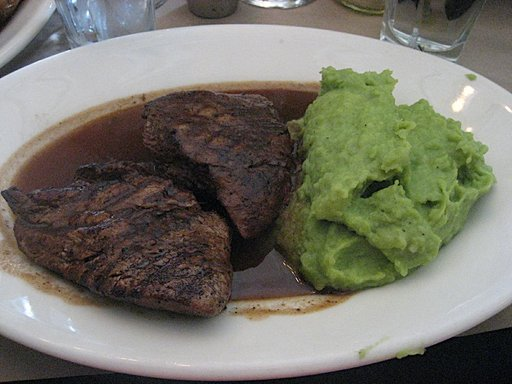

In [7]:
import random
from PIL import Image

image_path_list  = list(image_path.glob("*/*/*.jpg"))


random_image_path = random.choice(image_path_list)
print(random_image_path)


image_class = random_image_path.parent.stem
print(image_class)

img = Image.open(random_image_path)
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(np.float64(-0.5), np.float64(511.5), np.float64(383.5), np.float64(-0.5))

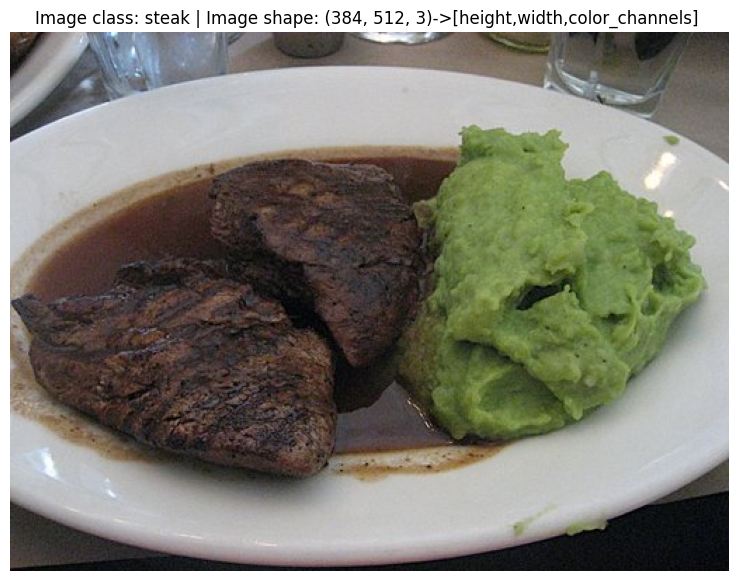

In [8]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape}->[height,width,color_channels] ")
plt.axis(False)


##3. Transforming Data

###3.1 Transforming data with torchvision.transforms

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [10]:

data_transform = transforms.Compose([transforms.Resize(size=(64,64)),
                                     transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.ToTensor()])

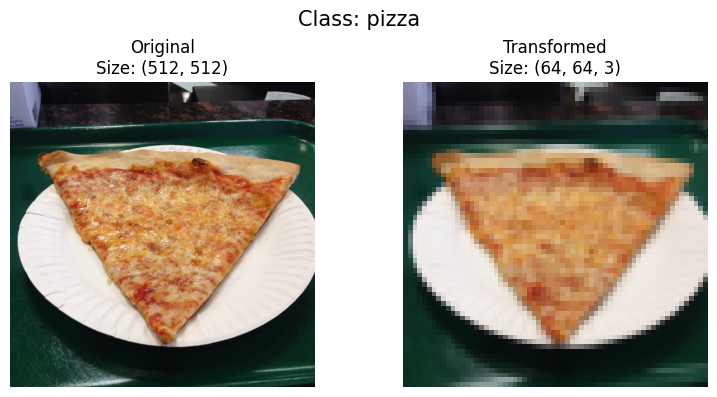

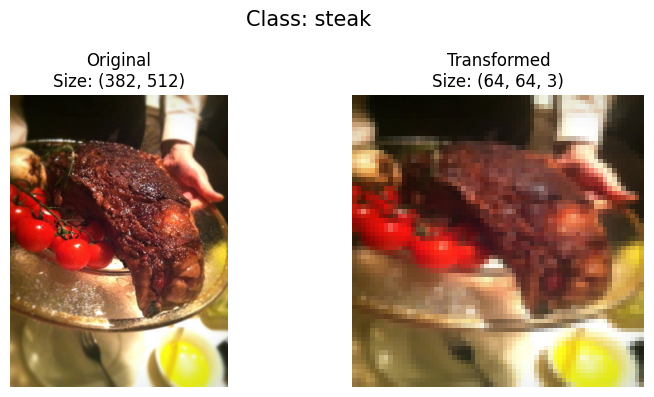

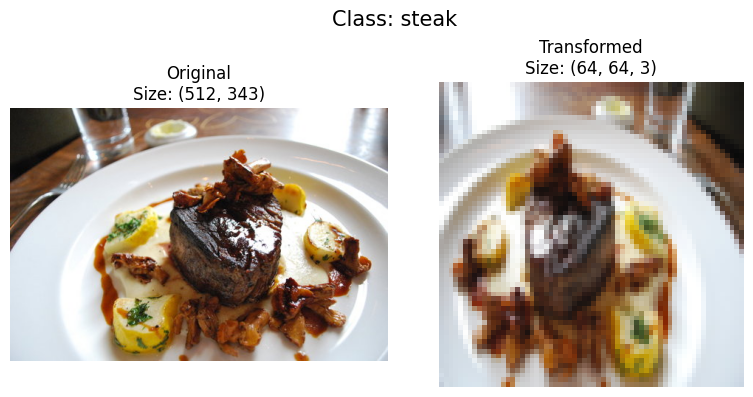

In [11]:
import random
import matplotlib.pyplot as plt
from PIL import Image

def plot_transform_images(image_path, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_path, k=n)

    for img_path in random_image_paths:
        with Image.open(img_path) as f:
            fig, ax = plt.subplots(1, 2, figsize=(8, 4))

            # Original
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis("off")

            # Transformed
            transformed_image = transform(f)
            transformed_image = (
                transformed_image.permute(1, 2, 0)
                .clamp(0, 1)
                .numpy()
            )

            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {img_path.parent.stem}", fontsize=15)
            plt.tight_layout()
            plt.show()

plot_transform_images(image_path_list,
                      data_transform,
                      n=3,
                      seed=42)


##4. Option 1: Loading Image Data Using [ImageFolder](https://docs.pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder)

In [13]:
from  torchvision import datasets, transforms

train_data  =  datasets.ImageFolder(root=train_dir,
                                    transform=data_transform,
                                    target_transform=None,
                                    )

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)


In [15]:
train_data

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [16]:
test_data

Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [17]:
train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [18]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [19]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [20]:
len(train_data), len(test_data)

(225, 75)

In [21]:
train_data.samples[:5]

[('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1033251.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1044789.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1089334.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1105700.jpg', 0)]

In [22]:
train_data[0]

(tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
          [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
          [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
          ...,
          [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
          [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
          [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],
 
         [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
          [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
          [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
          ...,
          [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
          [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
          [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],
 
         [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
          [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
          [0.0902, 0.0902, 0.0902,  ...,

In [23]:
img,label = train_data[0][0],train_data[0][1]
img,label,class_names[label]

(tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
          [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
          [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
          ...,
          [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
          [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
          [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],
 
         [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
          [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
          [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
          ...,
          [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
          [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
          [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],
 
         [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
          [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
          [0.0196, 0.0157, 0.0157,  ...,

In [ ]:
#class_names[label]

In [25]:
img,label = train_data[0][0],train_data[0][1]
print(f"Image shape: {img.shape}")
print(f"Label: {label}, Class: {class_names[label]}")
print(f"image datatype: {img.dtype}")
print(f"label datatype: {type(label)}")

Image shape: torch.Size([3, 64, 64])
Label: 0, Class: pizza
image datatype: torch.float32
label datatype: <class 'int'>


Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


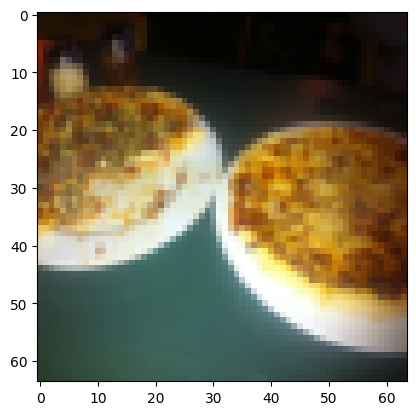

In [30]:
import matplotlib.pyplot as plt

img_permute = img.permute(1,2,0)
plt.imshow(image_permute)

print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")



##4.1 Turn loaded images into DataLoader's

In [33]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size = BATCH_SIZE,
                              num_workers = 1,
                              shuffle = True)


test_dataloader = DataLoader(dataset=test_data,
                             batch_size = BATCH_SIZE,
                             num_workers = 1,
                             shuffle = False)

train_dataloader,test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x7ccfb98c4c50>,
 <torch.utils.data.dataloader.DataLoader at 0x7ccfb98d6d50>)

In [35]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [37]:
img,lable = next(iter(train_dataloader))
print(f"Image shape {img.shape}  -> [batch_size,color_channels_height,width]")

Image shape torch.Size([32, 3, 64, 64])  -> [batch_size,color_channels_height,width]
